# Segmentation notebook used for https://github.com/CSAILVision/semantic-segmentation-pytorch repository to create road masking.

In [1]:
# System libs
import os
import argparse
from distutils.version import LooseVersion
# Numerical libs
import numpy as np
import torch
import torch.nn as nn
from scipy.io import loadmat
import csv
# Our libs
from mit_semseg.dataset import TestDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode, find_recursive, setup_logger
from mit_semseg.lib.nn import user_scattered_collate, async_copy_to
from mit_semseg.lib.utils import as_numpy
from PIL import Image
from tqdm import tqdm
from mit_semseg.config import cfg

import ntpath
import cv2
import matplotlib.pyplot as plt

In [6]:


colors = loadmat('/home/jared/Research/semantic-segmentation-pytorch/data/color150.mat')['colors']
names = {}
with open('/home/jared/Research/semantic-segmentation-pytorch/data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]


def visualize_result(data, pred, cfg):
    (img, info) = data

    # print predictions in descending order
    pred = np.int32(pred)
    pixs = pred.size
    uniques, counts = np.unique(pred, return_counts=True)
    print("Predictions in [{}]:".format(info))
    for idx in np.argsort(counts)[::-1]:
        name = names[uniques[idx] + 1]
        ratio = counts[idx] / pixs * 100
        if ratio > 0.1:
            print("  {}: {:.2f}%".format(name, ratio))

    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)

    # aggregate images and save
    im_vis = np.concatenate((img, pred_color), axis=1)

    img_name = info.split('/')[-1]
    Image.fromarray(im_vis).save(
        os.path.join(cfg.TEST.result, img_name.replace('.jpg', '.png')))


def test(segmentation_module, loader, gpu, save_path):
    segmentation_module.eval()

    pbar = tqdm(total=len(loader))
    for batch_data in loader:
        # process data
        batch_data = batch_data[0]
        segSize = (batch_data['img_ori'].shape[0],
                   batch_data['img_ori'].shape[1])
        img_resized_list = batch_data['img_data']

        with torch.no_grad():
            scores = torch.zeros(1, cfg.DATASET.num_class, segSize[0], segSize[1])
            scores = async_copy_to(scores, gpu)

            for img in img_resized_list:
                feed_dict = batch_data.copy()
                feed_dict['img_data'] = img
                del feed_dict['img_ori']
                del feed_dict['info']
                feed_dict = async_copy_to(feed_dict, gpu)

                # forward pass
                pred_tmp = segmentation_module(feed_dict, segSize=segSize)
                scores = scores + pred_tmp / len(cfg.DATASET.imgSizes)

            _, pred = torch.max(scores, dim=1)
            pred = as_numpy(pred.squeeze(0).cpu())

        img = batch_data['img_ori']
        img[pred != 6] = 0
        base = ntpath.basename(batch_data['info'])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path + base, img)
        # visualization
        """visualize_result(
            (batch_data['img_ori'], batch_data['info']),
            pred,
            cfg
        )
        """
        pred 
        pbar.update(1)


def main(cfg, gpu, save_path):
    torch.cuda.set_device(gpu)

    # Network Builders
    net_encoder = ModelBuilder.build_encoder(
        arch=cfg.MODEL.arch_encoder,
        fc_dim=cfg.MODEL.fc_dim,
        weights=cfg.MODEL.weights_encoder)
    net_decoder = ModelBuilder.build_decoder(
        arch=cfg.MODEL.arch_decoder,
        fc_dim=cfg.MODEL.fc_dim,
        num_class=cfg.DATASET.num_class,
        weights=cfg.MODEL.weights_decoder,
        use_softmax=True)

    crit = nn.NLLLoss(ignore_index=-1)

    segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)

    # Dataset and Loader
    dataset_test = TestDataset(
        cfg.list_test,
        cfg.DATASET)
    loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=cfg.TEST.batch_size,
        shuffle=False,
        collate_fn=user_scattered_collate,
        num_workers=5,
        drop_last=True)

    segmentation_module.cuda()

    # Main loop
    test(segmentation_module, loader_test, gpu, save_path)

    print('Inference done!')

In [7]:
def run():
    assert args.images != None
    assert args.save_path != None
    os.makedirs(save_path, exist_ok=True)

    cfg.merge_from_file(args.cfg)

    logger = setup_logger(distributed_rank=0)   # TODO
    logger.info("Loaded configuration file {}".format(args.cfg))
    logger.info("Running with config:\n{}".format(cfg))

    cfg.MODEL.arch_encoder = cfg.MODEL.arch_encoder.lower()
    cfg.MODEL.arch_decoder = cfg.MODEL.arch_decoder.lower()

    # absolute paths of model weights
    cfg.MODEL.weights_encoder = os.path.join(
        cfg.DIR, 'encoder_' + cfg.TEST.checkpoint)
    cfg.MODEL.weights_decoder = os.path.join(
        cfg.DIR, 'decoder_' + cfg.TEST.checkpoint)

    assert os.path.exists(cfg.MODEL.weights_encoder) and \
        os.path.exists(cfg.MODEL.weights_decoder), "checkpoint does not exitst!"

    # generate testing image list
    if os.path.isdir(args.imgs):
        imgs = find_recursive(args.imgs)
    else:
        imgs = [args.imgs]
    assert len(imgs), "imgs should be a path to image (.jpg) or directory."
    cfg.list_test = [{'fpath_img': x} for x in imgs]

    if not os.path.isdir(cfg.TEST.result):
        os.makedirs(cfg.TEST.result)

    main(cfg, args.gpu, args.save_path)

In [3]:
class Args(object):
    imgs = None
    save_path = None
    cfg = '/home/jared/Research/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml'
    gpu = [0, 1, 2, 3]
    opts = None
    
args = Args()

In [ ]:
#make training segmentation
args.imgs = '/home/jared/Research/speed_detection/data/train/images/'
save_path = '/home/jared/Research/speed_detection/data/train/mask_road_images/'

run()

In [9]:
#make validation segmentation
args.imgs = '/home/jared/Research/speed_detection/data/val/images/'
save_path = '/home/jared/Research/speed_detection/data/val/mask_road_images/'

run()

[2020-12-03 18:14:28,012 INFO <ipython-input-7-d7684c701d5c> line 7 23733] Loaded configuration file /home/jared/Research/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2020-12-03 18:14:28,012 INFO <ipython-input-7-d7684c701d5c> line 7 23733] Loaded configuration file /home/jared/Research/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2020-12-03 18:14:28,018 INFO <ipython-input-7-d7684c701d5c> line 8 23733] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet50dilated
  fc_dim: 2048
  weights_decoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
  weights_encoder: ckpt/ade20k-resnet50dilated-ppm_d

[2020-12-03 18:14:28,018 INFO <ipython-input-7-d7684c701d5c> line 8 23733] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet50dilated
  fc_dim: 2048
  weights_decoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
  weights_encoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
TEST:
  batch_size: 1
  checkpoint: epoch_20.pth
  result: ./
TRAIN:
  batch_size_per_gpu: 2
  beta1: 0.9
  deep_sup_scale: 0.4
  disp_iter: 20
  epoch_iters: 5000
  fix_bn: False
  lr_decoder: 0.02
  lr_encoder: 0.02
  lr_pow: 0.9
  num_epoch: 20
  optim: SGD
  seed: 304
  start_epoch: 0
  weight_decay: 0.0001
  workers: 16
VAL:
  batch_size: 1
  checkpoint: epoch_20

Loading weights for net_encoder


  0%|          | 0/4080 [00:00<?, ?it/s]

Loading weights for net_decoder
# samples: 4080


100%|██████████| 4080/4080 [20:46<00:00,  3.52it/s]

Inference done!


In [11]:
#make holdout segmentation
args.imgs = '/home/jared/Research/speed_detection/data/holdout/images/'
args.save_path = '/home/jared/Research/speed_detection/data/holdout/mask_road_images/'

run()

[2020-12-03 18:35:15,543 INFO <ipython-input-7-d7684c701d5c> line 7 23733] Loaded configuration file /home/jared/Research/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2020-12-03 18:35:15,543 INFO <ipython-input-7-d7684c701d5c> line 7 23733] Loaded configuration file /home/jared/Research/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2020-12-03 18:35:15,543 INFO <ipython-input-7-d7684c701d5c> line 7 23733] Loaded configuration file /home/jared/Research/semantic-segmentation-pytorch/config/ade20k-resnet50dilated-ppm_deepsup.yaml
[2020-12-03 18:35:15,552 INFO <ipython-input-7-d7684c701d5c> line 8 23733] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_d

[2020-12-03 18:35:15,552 INFO <ipython-input-7-d7684c701d5c> line 8 23733] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet50dilated
  fc_dim: 2048
  weights_decoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
  weights_encoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
TEST:
  batch_size: 1
  checkpoint: epoch_20.pth
  result: ./
TRAIN:
  batch_size_per_gpu: 2
  beta1: 0.9
  deep_sup_scale: 0.4
  disp_iter: 20
  epoch_iters: 5000
  fix_bn: False
  lr_decoder: 0.02
  lr_encoder: 0.02
  lr_pow: 0.9
  num_epoch: 20
  optim: SGD
  seed: 304
  start_epoch: 0
  weight_decay: 0.0001
  workers: 16
VAL:
  batch_size: 1
  checkpoint: epoch_20

[2020-12-03 18:35:15,552 INFO <ipython-input-7-d7684c701d5c> line 8 23733] Running with config:
DATASET:
  imgMaxSize: 1000
  imgSizes: (300, 375, 450, 525, 600)
  list_train: ./data/training.odgt
  list_val: ./data/validation.odgt
  num_class: 150
  padding_constant: 8
  random_flip: True
  root_dataset: ./data/
  segm_downsampling_rate: 8
DIR: ckpt/ade20k-resnet50dilated-ppm_deepsup
MODEL:
  arch_decoder: ppm_deepsup
  arch_encoder: resnet50dilated
  fc_dim: 2048
  weights_decoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth
  weights_encoder: ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth
TEST:
  batch_size: 1
  checkpoint: epoch_20.pth
  result: ./
TRAIN:
  batch_size_per_gpu: 2
  beta1: 0.9
  deep_sup_scale: 0.4
  disp_iter: 20
  epoch_iters: 5000
  fix_bn: False
  lr_decoder: 0.02
  lr_encoder: 0.02
  lr_pow: 0.9
  num_epoch: 20
  optim: SGD
  seed: 304
  start_epoch: 0
  weight_decay: 0.0001
  workers: 16
VAL:
  batch_size: 1
  checkpoint: epoch_20

Loading weights for net_encoder



  0%|          | 0/2040 [00:00<?, ?it/s]

Loading weights for net_decoder
# samples: 2040



 15%|█▍        | 304/2040 [01:33<08:38,  3.35it/s]


 30%|██▉       | 606/2040 [03:06<07:17,  3.28it/s]


 45%|████▍     | 908/2040 [04:39<05:52,  3.21it/s]


 59%|█████▉    | 1206/2040 [06:10<04:18,  3.23it/s]


 74%|███████▎  | 1502/2040 [07:42<02:56,  3.04it/s]


 88%|████████▊ | 1798/2040 [09:13<01:14,  3.24it/s]


100%|██████████| 2040/2040 [10:28<00:00,  3.49it/s]

Inference done!


In [5]:
train_frame1 = cv2.cvtColor(cv2.imread('/home/jared/Research/speed_detection/data/train/mask_road_images/0.jpg'), 
                            cv2.COLOR_BGR2RGB)
val_frame1 = cv2.cvtColor(cv2.imread('/home/jared/Research/speed_detection/data/val/mask_road_images/15867.jpg'), 
                          cv2.COLOR_BGR2RGB)
holdout_frame1 = cv2.cvtColor(cv2.imread('/home/jared/Research/speed_detection/data/holdout/mask_road_images/19157.jpg'), 
                              cv2.COLOR_BGR2RGB)

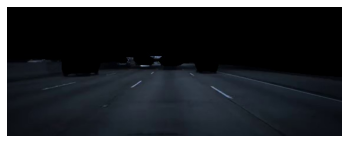

In [6]:
plt.axis('off')
plt.imshow(train_frame1)

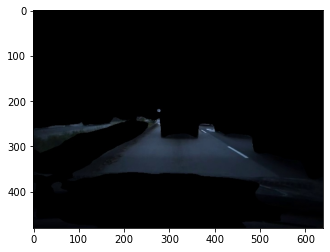

In [16]:
plt.imshow(val_frame1)

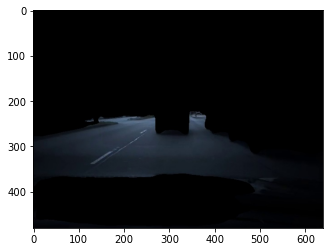

In [18]:
plt.imshow(holdout_frame1)